# RAIL/estimation Tutorial Notebook

author: Sam Schmidt, Eric Charles, others...<br>
last run successfully: March 12, 2022<br>

(FIXME, workaround for bug in mixmod PDF triggered in new version of scipy)

This is a notebook demonstrating some of the features of the LSSTDESC `RAIL` package, namely the features of `estimation`.  `RAIL/estimation` is the interface for running production level photo-z codes within DESC.  There is a minimimal superclass that sets up some file paths and variable names, each specific photo-z code resides in a subclass with code-specific setup variables.<br>

RAIL is available at:<br>
https://github.com/LSSTDESC/RAIL<br>
and must be installed and included in your python path to work.  The LSSTDESC `qp` package that handles PDF files is also required, it is available at:<br>
https://github.com/LSSTDESC/qp<br>


In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

%matplotlib inline 

In [3]:
import sys
sys.path.append('/net/home/fohlen13/yanza21/research/src/RAIL_new/RAIL/')

import rail
import ceci
ceci.stage.PipelineStage.allow_reload = True
import qp
from rail.core.data import TableHandle
from rail.core.stage import RailStage

/net/home/fohlen13/yanza21/anaconda3/envs/rail/lib/python3.8/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '
/net/home/fohlen13/yanza21/anaconda3/envs/rail/lib/python3.8/site-packages/jax/experimental/stax.py:28: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  warnings.warn('jax.experimental.stax is deprecated, '
/net/home/fohlen13/yanza21/anaconda3/envs/rail/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [4]:
rail

<module 'rail' from '/net/home/fohlen13/yanza21/anaconda3/envs/rail/lib/python3.8/site-packages/rail/__init__.py'>

We'll start by setting up the Rail data store.  RAIL uses [ceci](https://github.com/LSSTDESC/ceci), which is designed for pipelines rather than interactive notebooks, the data store will work around that and enable us to use data interactively.  This is a slight hack, and we will have some files appearing in the data store with the prefix "inprogress_" as they are stored in memory.  See the `rail/examples/goldenspike/goldenspike.ipynb` example notebook for more details on the Data Store.

In [3]:
DS = RailStage.data_store
DS.__class__.allow_overwrite = True

In [6]:
import matplotlib.pyplot as plt
from pzflow.examples import get_example_flow
from rail.creation import engines
from rail.core.stage import RailStage
from rail.creation.degradation import (
    InvRedshiftIncompleteness,
    LineConfusion,
    LSSTErrorModel,
    QuantityCut,
)

import pzflow
import os
flow_file = os.path.join(os.path.dirname(pzflow.__file__), 'examples', 'example-flow.pkl')

n_samples = int(1e5)
flowEngine_truth = engines.FlowEngine.make_stage(name='truth', flow=flow_file, n_samples=n_samples)

DS = RailStage.data_store
DS.__class__.allow_overwrite = True

flowEngine_truth.get_data('flow')

samples_truth = flowEngine_truth.sample(n_samples, seed=0)
#print(samples_truth.data)
#print("Data was written to ", samples_truth.path)

Inserting handle into data store.  flow: /net/home/fohlen13/yanza21/anaconda3/envs/rail/lib/python3.8/site-packages/pzflow/examples/example-flow.pkl, truth
Inserting handle into data store.  output_truth: inprogress_output_truth.pq, truth


In [7]:
samples_truth.data

,redshift,u,g,r,i,z,y
0,0.654000,28.262444,27.335606,26.053682,25.258146,25.094685,24.961941
1,1.445551,24.633509,24.454756,24.367916,24.036932,23.744223,23.265099
2,0.980286,25.869593,25.591894,25.014988,24.306276,23.757196,23.583630
3,1.974136,25.846521,25.676571,25.428736,25.334469,25.052134,24.839678
4,1.573981,27.529625,27.227512,26.901337,26.430315,26.164469,25.778555
...,...,...,...,...,...,...,...
99995,0.537298,28.622873,27.595121,26.410727,25.795841,25.547186,25.322063
99996,0.365364,28.490147,27.377586,26.312820,25.961052,25.675964,25.611153
99997,0.621117,27.889215,26.828249,25.556490,24.797277,24.600286,24.425396
99998,0.814658,27.907330,27.212503,26.510286,25.718790,25.455593,25.358885


In [8]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/net/home/fohlen13/yanza21/research/src/RAIL_new/RAIL/rail/creation/degradation')
import lsst_error_model_extended
#from importlib import reload
#reload(lsst_error_model_extended)
from lsst_error_model_extended import LSSTErrorModel_extended

#from lsst_error_model_extended import *
#from lsst_error_model import *



# Generate a base catalog with the flow engine

In [9]:
from pzflow import Flow
import os
flowEngine = Flow(file=os.path.expanduser('~')+"/DATA/flows/cosmoDC2_example_flow.pkl")
n_samples = int(1e4)
flowEngine_truth = engines.FlowEngine.make_stage(name='truth',
                                                 flow=os.path.expanduser('~')+"/DATA/flows/cosmoDC2_example_flow.pkl", 
                                                 n_samples=n_samples)

# Add magnitude errors

In [10]:
errorModel = LSSTErrorModel.make_stage(name='error_model', highSNR=True)
errorModel_extended = LSSTErrorModel_extended.make_stage(name='error_model_extended',
                                                        errortype="gaap", highSNR=False)
samples_w_errs = errorModel(samples_truth)

Inserting handle into data store.  output_error_model: inprogress_output_error_model.pq, error_model


# Perform spectroscopic selections

In [8]:
import sys
sys.path.append('/net/home/fohlen13/yanza21/research/src/RAIL_new/RAIL/rail/creation/degradation')
import spec_selection_v2
from spec_selection_v2 import *

specselect = SpecSelection_zCOSMOS.make_stage(N_tot=100000)
samples_selected = specselect(samples_w_errs)

Inserting handle into data store.  output: inprogress_output.pq, specselection_zCOSMOS


# Measure BPZ

In [11]:
import sys
sys.path.append('/net/home/fohlen13/yanza21/research/src/RAIL_new/RAIL/rail/estimation/algos')
import rail.estimation.algos.bpz_lite
#reload(rail.estimation.algos.bpz_lite_zy)

from rail.estimation.algos.bpz_lite import BPZ_lite
from importlib import reload

bpz = BPZ_lite.make_stage(name='bpz', hdf5_groupname="", columns_file='./configs/test_bpz_zy.columns', 
                             mag_colname="{}", mag_err_colname="{}_err")


In [13]:
bpz.config

StageConfig{output_mode:default,chunk_size:10000,hdf5_groupname:,zmin:0.0,zmax:3.0,dz:0.01,nzbins:301,band_names:['mag_u_lsst', 'mag_g_lsst', 'mag_r_lsst', 'mag_i_lsst', 'mag_z_lsst', 'mag_y_lsst'],band_err_names:['mag_err_u_lsst', 'mag_err_g_lsst', 'mag_err_r_lsst', 'mag_err_i_lsst', 'mag_err_z_lsst', 'mag_err_y_lsst'],nondetect_val:99.0,data_path:None,columns_file:./configs/test_bpz_zy.columns,spectra_file:SED/CWWSB4.list,madau_flag:no,mag_limits:{'mag_u_lsst': 27.79, 'mag_g_lsst': 29.04, 'mag_r_lsst': 29.06, 'mag_i_lsst': 28.62, 'mag_z_lsst': 27.98, 'mag_y_lsst': 27.05},prior_band:mag_i_lsst,prior_file:hdfn_gen,p_min:0.005,gauss_kernel:0.0,zp_errors:[0.01, 0.01, 0.01, 0.01, 0.01, 0.01],mag_err_min:0.005,name:bpz,mag_colname:{},mag_err_colname:{}_err,config:None,input:None,aliases:{'output': 'output_bpz', 'input': 'output'},}

In [12]:
results = bpz.estimate(samples_selected)

KeyError: 'mag_u_lsst'

In [17]:
zmode = results.data.ancil['zmode']

# The mode computation for mix_mod pdf is broken with the new scipy, but we can get easily
# get the peak of the largest contributor
whichone = np.argmax(results.data.dist.weights, axis=1)
zmode = np.array([means_[whichone_] for means_, whichone_ in zip(results.data.dist.means, whichone)])

# Plots

Text(0, 0.5, 'BPZ')

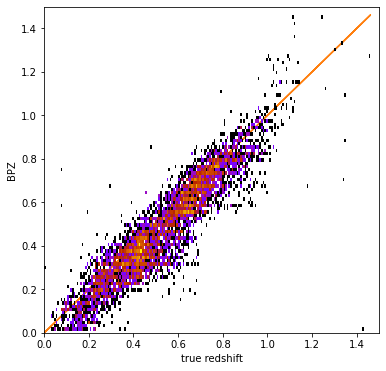

In [18]:
import copy
import matplotlib as mpl

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

%matplotlib inline 
my_cmap = copy.copy(plt.cm.get_cmap("gnuplot"))
my_cmap.set_under('w',0.1)

fig = plt.figure(figsize=(6,6))

h=plt.hist2d(samples_selected.data['redshift'], results.data.ancil['zmode'], bins=(200,200), norm=mpl.colors.LogNorm(), cmap=my_cmap)
plt.xlabel('z_spec')
plt.ylabel('z_B')
plt.xlim(0, 1.5)
plt.ylim(0, 1.5)
plt.plot(samples_selected.data['redshift'],samples_selected.data['redshift'], color='C1', zorder=0)

plt.xlabel("true redshift")
plt.ylabel("BPZ")

In [19]:
sys.path.append('/net/home/fohlen13/yanza21/research/projects/dc2_mock/plotting/')

In [20]:
zspec = samples_selected.data['redshift']
z_b = results.data.ancil['zmode']
mag_r = samples_selected.data['r']

/net/home/fohlen13/yanza21/research/projects/dc2_mock/plotting/plots_zy.py:57: RuntimeWarning: invalid value encountered in true_divide
  np.abs(stat[bin_mask] - (dzs/znorms)[i]))
/net/home/fohlen13/yanza21/anaconda3/envs/rail/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/net/home/fohlen13/yanza21/anaconda3/envs/rail/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/net/home/fohlen13/yanza21/research/projects/dc2_mock/plotting/plots_zy.py:57: RuntimeWarning: invalid value encountered in true_divide
  np.abs(stat[bin_mask] - (dzs/znorms)[i]))
/net/home/fohlen13/yanza21/anaconda3/envs/rail/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/net/home/fohlen13/yanza21/anaconda3/envs/rail/lib

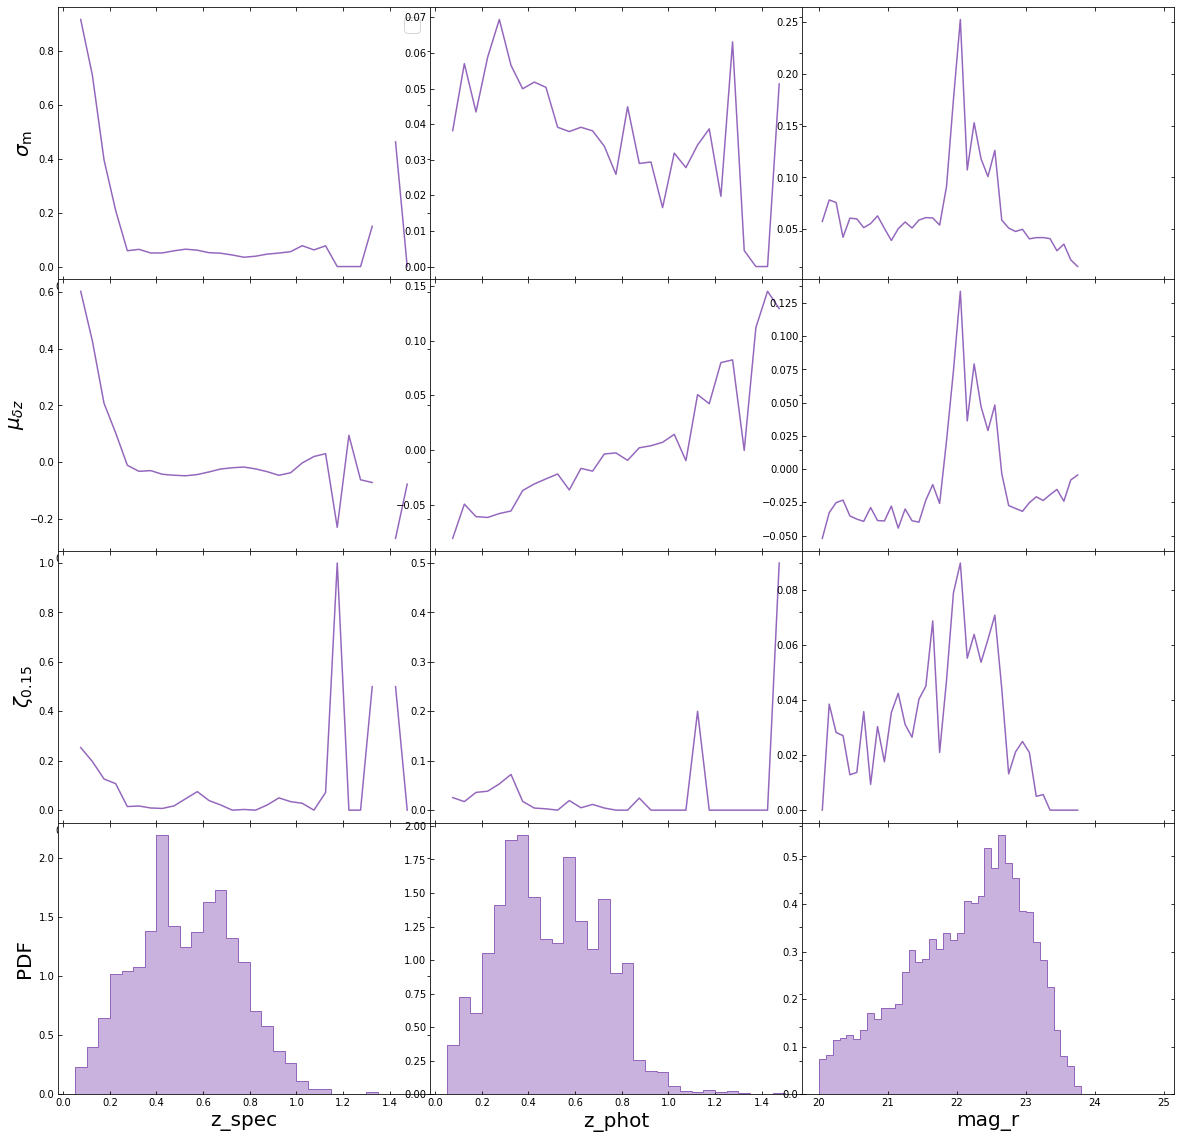

In [21]:
import plots_zy as plot

ig, axes = plt.subplots(4,3, figsize=(20, 20))
plot.plot_BPZ_stats(zspec, z_b, mag_r, axes, color='C4'
                    ,)

axes[0][0].legend(fontsize=20)

for i in range(4):
    for j in range(3):
        axes[i][j].tick_params("both", direction="in",
                bottom=True, top=True, left=True, right=True)
        #axes[i][j].sharey(axes[i][0])
        axes[i][j].sharex(axes[0][j])
        axes[i][j].xaxis.label.set_size(20)
        axes[i][j].yaxis.label.set_size(20)

#axes[0][2].set_ylim(0, 0.2)
#axes[1][2].set_ylim(-0.2, 0.2)
plt.subplots_adjust(wspace=0, hspace=0) 